In [40]:
from dotenv import load_dotenv

load_dotenv()

True

In [41]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function = embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)

retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [42]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [43]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다.

In [44]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [45]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model='gpt-4o-mini', max_completion_tokens=100)
def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response}

In [46]:
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain import hub
from typing import Literal
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelvant']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'relevant'

    return 'irrelvant'

In [47]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template("""사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요
질문: {query}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
         state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 stat를 반환합니다.
    """
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    return {'query': response}

In [48]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

def web_search(state: AgentState):
    query = state['query']
    results = tavily_search_tool.invoke(query)
    return {'content': results}

In [49]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

In [50]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant':'generate',
        'irrelvant':'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [51]:
graph = graph_builder.compile()

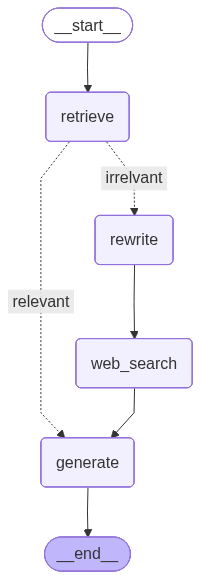

In [52]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
initial_state = {'query': '연봉 5천만원의 거주자의 소득세는 얼마인가?'}
graph.invoke(initial_state)

{'query': '연봉 5천만원의 거주자의 소득세는 얼마인가?',
 'context': [Document(id='30d76fab-2884-47d1-a9da-a55bd1fd2b79', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 20

In [54]:
initial_state = {'query': '역삼역 맛집을 추천해주세요'}
graph.invoke(initial_state)

{'query': '역삼역 근처 맛집 추천 부탁드립니다.',
 'context': [Document(id='3e64ee55-cd7b-41a3-8269-28ad727664c4', metadata={'source': './documents/income_tax.txt'}, page_content='1. ‘세무처리’에 따른 세무조정을 통합한 세무서\n2. ‘세무조정’에 따른 세무조정방식으로 세무거래명부부록에 등록한 공인회계사\n3. ‘세무처리’에 따른 세무조정 또는 변호사 세무거래명부부록에 등록한 변호사\n[전문개정 2009. 12. 31.]\n[2021. 11. 23. 법률 제18521호에 의하여 2018. 4. 26. 헌법재판소에서 헌법불합치 결정에 의한 조치를 개정하였다.]\n제070조(종합소득과세표준 확정신고) ③ 해당 과세기간에 병립과세 주택매도소득, 제273조제1항제27조 및 제127조제1항제6호나목의 소득이 있는 경우에도 제126항에 따른 “종합소득 과세표준확정신고서”라 한다.\n➄ 종합소득과세표준확정신고를 할 때에는 “신고서”의 다음 각 호의 서류를 첨부하여 납세자에게 제출하여야 한다. 이 경우 제160조제3항에 따른 복식부기의무자가 제630호에 따른 세무를 제출하지 아니하는 경우에는 종합소득 과세표준확정신고로 하지 아니하는 것으로 본다.<개정 2010. 12. 27. 2012. 1. 1. 2014. 1. 1.>\n1. 인적증명, 연구보고서, 주택보조금부록, 특별소득증명, 자녀세액공제, 연금계좌세액공제 및 특별세액에 대한 내용을 증명하는 서류로서 대통령령으로 정하는 것\n2. 종합소득액의 계산이 기초한 총수입금액의 계산에 필요한 서류로서 대통령령으로 정하는 것\n3. 사업소득금액 제160조 및 제161조의2에 따른 비치·기록할 장부의 증명서류에 의하여 계산하지 아니하는 경우에는 기획재정부로 정하는 재무제표·손익계산서와 부속서류, 현황재무제표(現況財務表) 및 대통령령으로 정하는 바에 따라 작성한 조정계산서. 다만, 제160조제1항에 따라 기상(基商)을 한